# 목표

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- CNN에서 합성곱이 어떤식으로 처리되는지 이해
  - 데이터의 변화 확인(이미지)
- CNN에서 풀링이 어떤식으로 처리되는지 이해
  - 데이터의 변화 확인(이미지)
- 편향, 패딩은 고정하고 사용
- x, W, s, p 간의 공식 확인
- W를 직접 설계(수직, 수평, 빛의 방향 검토)

In [2]:
import torch
torch.__version__

'1.11.0+cu113'

# 이미지 준비

In [3]:
import matplotlib.pyplot as plt
# Plilow
from PIL import Image

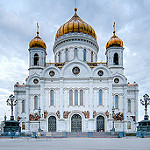

In [4]:
img = Image.open('/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/dl/torch3.png')
img

In [5]:
import numpy as np

In [6]:
tmp = np.array( img )
tmp.shape, img.size
# (세로, 가로, 채널)

((150, 150, 3), (150, 150))

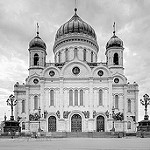

In [7]:
# 칼라이미지를 grayscale로 처리해서 1채널 이미지로 컨버팅
img = img.convert("L")
# L = R*(299/1000) + G*(나머지값/1000) + B*(114/1000)
img

In [8]:
# 1채널 이미지라서 채널값 자체가 사라졌다
tmp = np.array( img )
tmp.shape, img.size

((150, 150), (150, 150))

In [9]:
img_Tensor = torch.Tensor(tmp)
img_Tensor.size()

torch.Size([150, 150])

In [10]:
img_Tensor, img_Tensor.min(), img_Tensor.max()

(tensor([[212., 213., 215.,  ..., 197., 199., 200.],
         [215., 216., 216.,  ..., 197., 199., 200.],
         [214., 215., 216.,  ..., 196., 197., 198.],
         ...,
         [171., 171., 172.,  ..., 163., 166., 161.],
         [174., 174., 174.,  ..., 173., 175., 168.],
         [168., 168., 168.,  ..., 158., 159., 150.]]),
 tensor(0.),
 tensor(255.))

# 합성곱 구현

In [11]:
# 1. 커널 준비 : 가중치 W를 공용파라미터로 가진 커널(필터)
#                이미지 상의 공간정보, 인접정보 등 특징 추출 용도
#                이런 특징이 어떤 것 들인가? 수직, 수평 성분 추출
# 특정 크기를 가진 커널에 수직 수평정보를 추출하는 W를 가진 
# 값을 넣어서 합성곱 과정을 수행
kernel = torch.Tensor([
  [1, 0, -1],
  [1, 0, -1],
  [1, 0, -1]
])
kernel, kernel.size()

(tensor([[ 1.,  0., -1.],
         [ 1.,  0., -1.],
         [ 1.,  0., -1.]]), torch.Size([3, 3]))

In [12]:
# 수평커널
kernel.T

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])

In [13]:
# 이미지 높이, 너비
height, width = img_Tensor.size()
height, width

(150, 150)

In [14]:
# stride 값
stride = 1

In [15]:
# 이미지상의 좌표 -> 4/4 분면 사용
# 왼쪽 상단 귀퉁이가 (0,0) 이다 

# 실제 구현

In [16]:
k_h, k_w = kernel.size()

In [17]:
# 세로방향 이동
for i in range(0, height-k_h+1, stride):   # 높이 
  # 가로 한줄에 대한 특징 추출이 끝나면 담는 그릇
  tmp = list()
  for j in range(0, width-k_w+1, stride): # 너비
    # 목표 : 이미지 공간상에 있는 정보를 추출한다
    # 1. 커널과 겹쳐있는 이미지 데이터를 추출
    img_target = img_Tensor[ i:(i+k_h) , j:(j+k_w) ]
    # 2. 연산 ( 행렬간 곱을 수행후 원소 합산 => 내적)
    print( img_target )
    print( img_target * kernel )
    print( torch.sum( img_target * kernel ) )
    tmp.append( torch.sum( img_target * kernel ) )
    # 내적 수행시 오류가 발생 -=> 원인 나중 체크
    #print( torch.dot( img_target, kernel ) )
    break
    pass
  break
  pass

tensor([[212., 213., 215.],
        [215., 216., 216.],
        [214., 215., 216.]])
tensor([[ 212.,    0., -215.],
        [ 215.,    0., -216.],
        [ 214.,    0., -216.]])
tensor(-6.)


In [18]:
finalMap = list()
for i in range(0, height-k_h+1, stride):   # 높이 
  tmp = list()
  for j in range(0, width-k_w+1, stride):  # 너비
    img_target = img_Tensor[ i:(i+k_h) , j:(j+k_w) ]
    tmp.append( torch.sum( img_target * kernel ) )
  finalMap.append( tmp )

conv1_img = torch.Tensor( finalMap )
conv1_img.size()

torch.Size([148, 148])

In [19]:
# 함성곱층의 커스텀 함수화
def myConvolution_Func( x, kernal, stride=(1,1)):
  '''
    직적 구현한(일부조건은 고정)합성곱함수
    x : 원본이미지
    kernal : 가중치 W를 공용파라미터로 가진 커널
  '''
  # shape 계산
  x_h, x_w = x.size()
  k_h, k_w = kernal.size()
  s_h, s_w = stride

  finalMap = list()
  for i in range(0, x_h-k_h+1, s_h):   # 높이 
    tmp = list()
    for j in range(0, x_w-k_w+1, s_w):  # 너비      
      tmp.append(torch.sum(img_Tensor[i:(i+k_h),j:(j+k_w)]*kernal))
    finalMap.append( tmp )
  
  return torch.Tensor( finalMap )

In [20]:
img_Tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [214., 215., 216.,  ..., 196., 197., 198.],
        ...,
        [171., 171., 172.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 173., 175., 168.],
        [168., 168., 168.,  ..., 158., 159., 150.]])

In [21]:
kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

In [22]:
vertical_conv_img = myConvolution_Func(img_Tensor, kernel)
vertical_conv_img

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])

In [23]:
# 수평커널 적용
horizontal_conv_img = myConvolution_Func(img_Tensor, kernel.T)
horizontal_conv_img

tensor([[ -5.,  -4.,  -3.,  ...,   5.,   5.,   5.],
        [ 16.,  13.,   7.,  ...,   3.,   8.,  13.],
        [ 28.,  23.,  14.,  ...,   2.,   8.,  15.],
        ...,
        [-27., -30., -32.,  ...,  19.,  21.,  22.],
        [-42., -44., -46.,  ...,  -2.,   1.,   6.],
        [ 10.,  11.,  13.,  ...,  15.,  17.,  23.]])

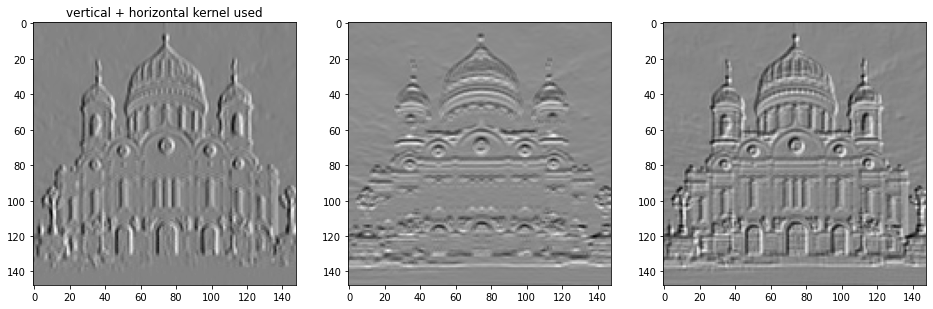

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=(16,9))

# 수직 커널 적용 
ax1.imshow(vertical_conv_img, cmap = 'binary')
ax1.set_title('vertical kernel used')

# 수평 커널 적용
ax2.imshow( horizontal_conv_img, cmap='binary' )
ax1.set_title('horizontal kernel used')

# 수직+수평동시 적용
ax3.imshow( vertical_conv_img + horizontal_conv_img, cmap='binary' )
ax1.set_title('vertical + horizontal kernel used')

plt.show()

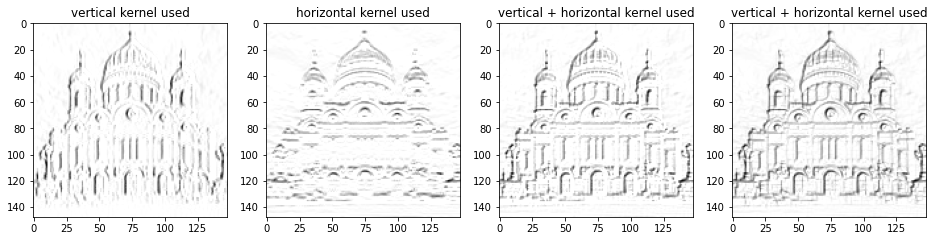

In [25]:
# 활성화 함수를 사용하여 음수값(이미지 픽셀중) 처리
fig, (ax1, ax2, ax3, ax4) = plt.subplots( 1, 4, figsize=(16,9))

# 수직 커널 적용 
ax1.imshow( torch.relu( vertical_conv_img ), cmap='binary' )
ax1.set_title('vertical kernel used')

# 수평 커널 적용
ax2.imshow( torch.relu( horizontal_conv_img), cmap='binary' )
ax2.set_title('horizontal kernel used')

# 수직+수평동시 적용
ax3.imshow( torch.relu( vertical_conv_img + horizontal_conv_img), cmap='binary' )
ax3.set_title('vertical + horizontal kernel used')

# 각각 활성화를 처리하여 합산하는 경우 -> 정보(특징이 명확했다)가 정확했다
ax4.imshow( torch.relu( vertical_conv_img) + torch.relu( horizontal_conv_img), cmap='binary' )
ax4.set_title('vertical + horizontal kernel used')

plt.show()

# API로 확인

In [26]:
import torch.nn as nn

In [27]:
# 엔진별로 이미지 포멧을 사용 (파이토치) => NCHW
# ( 1, 1, 150, 150 )
h, w = img_Tensor.size()

In [28]:
# 차원 변경
curImg = img_Tensor.view( 1, 1, h, w )
curImg.size()

torch.Size([1, 1, 150, 150])

In [29]:
# 차원을 확장 (2D -> 4D)
curImg = img_Tensor.expand( 1, 1, h, w )
curImg.size()

torch.Size([1, 1, 150, 150])

In [30]:
batch, in_channel, h, w = curImg.size()
# 설정값
out_channel = 1
kernel_size = 3
stride = 1

In [31]:
# api를 이용한 합성곱 생성
conv_layer = nn.Conv2d(
  in_channels = in_channel,
  out_channels = out_channel,
  kernel_size = kernel_size,
  stride = stride,
  bias = False
)

In [32]:
conv_layer

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [33]:
# 기본값으로 가중치값이 설정되어 있다
conv_layer.weight.data, conv_layer.weight.data.size()

(tensor([[[[ 0.2307, -0.0514,  0.2435],
           [-0.2174, -0.2933,  0.1098],
           [ 0.1222,  0.2328,  0.0254]]]]), torch.Size([1, 1, 3, 3]))

In [34]:
# 가중치에 수직 커널값 입력
conv_layer.weight.data = kernel.expand( 1, 1, 
                            kernel.size(0), kernel.size(1) )
conv_layer.weight.data

tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])

In [35]:
convs = conv_layer(curImg)
convs.size()
# [1, 1, 148, 148] => [148, 148]

torch.Size([1, 1, 148, 148])

In [36]:
convs.squeeze().size()

torch.Size([148, 148])

In [37]:
convs.squeeze() == vertical_conv_img

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

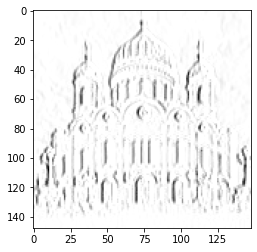

In [38]:
# 합성곱 api를 활용하면 내부적으로 미분이 걸려 있어서 
# 락이 되어 있다 -> 해제후 처리 -> detach() (락을 걸어서 출력할 수 있게 한다)
plt.imshow(torch.relu(convs.squeeze()).detach().numpy(), cmap = 'binary')
plt.show()

# 관계식

- k(W), s, p, h, w
  - 커널, 스트라이드, 패딩, 이미지높이/너비
  - 합성곱 통과후 이미지 높이
    - H = ((h + 2*P - K)/S) + 1
      - ((150 + 2*0 - 3)/1) + 1
      - ((150 - 3)/1) + 1
      - ((147)/1) + 1
      - 148
    - H = ((w + 2*P = K)/S) + 1

- 이를 이용해 합성곱층을 통과하는 이미지의 변화를 미리 예측해서 설계할 수 있다

# 최대 풀링 구현

In [39]:
activation_map = torch.relu(vertical_conv_img)
activation_map

tensor([[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [ 0.,  1.,  2.,  ...,  2.,  0.,  5.],
        [ 0.,  0.,  0.,  ...,  4.,  2.,  8.],
        [ 0.,  0.,  0.,  ...,  4.,  6., 15.]])

In [40]:
# 커널 사이즈
kernel_size = 2
# 이동량
stride_size = 2
# (148,148) => (74,74) 예측, 특성이 강화된다 본질 체크

- 풀링 처리를 위해 텐서쪽 지원함수 활용, unfold() 활용

In [41]:
tmp = torch.arange(0, 16).view(1,1,4,4)
tmp

tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]])

In [42]:
# unfold를 이용해 maxpoolor avr pool을 처리할 대상을 추출한다
# kernel => 2번인자 고려, stride는 3번인자를 고려해서 
# demonstion => 2
tmp.unfold(2, 2, 2), tmp.unfold(2, 2, 2).size()

(tensor([[[[[ 0,  4],
            [ 1,  5],
            [ 2,  6],
            [ 3,  7]],
 
           [[ 8, 12],
            [ 9, 13],
            [10, 14],
            [11, 15]]]]]), torch.Size([1, 1, 2, 4, 2]))

In [43]:
# 풀링의 대상이 되는 원소끼리 묶어 두었다
tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ), tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).size()

(tensor([[[[[[ 0,  1],
             [ 4,  5]],
 
            [[ 2,  3],
             [ 6,  7]]],
 
 
           [[[ 8,  9],
             [12, 13]],
 
            [[10, 11],
             [14, 15]]]]]]), torch.Size([1, 1, 2, 2, 2, 2]))

In [44]:
# 각 요소의 최하위 차원에서 max를 구한다
tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).max(-1)[0]

tensor([[[[[ 1,  5],
           [ 3,  7]],

          [[ 9, 13],
           [11, 15]]]]])

In [45]:
tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).max(-1)[0].max(-1)[0]

tensor([[[[ 5,  7],
          [13, 15]]]])

In [46]:
xh, xw = activation_map.size()

In [47]:
activation_map = activation_map.expand(1, 1, xh, xw)

In [48]:
activation_map.size()

torch.Size([1, 1, 148, 148])

In [49]:
# 최종 풀링 함수
def maxPooling( x, kSzie, stride=None):
  if not stride:
    # 커널과 동일한 크기로 설정
    stride = kSzie
  
  return x.unfold( 2, kSzie, 2 ).unfold( 3, 2, 2 ).max(-1)[0].max(-1)[0]
poolmap = maxPooling(activation_map, kernel_size, stride_size)
poolmap.size()

torch.Size([1, 1, 74, 74])

# api 확인

In [50]:
poolingLayer = nn.MaxPool2d(kernel_size, stride_size)
poolingLayer

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [51]:
pMap = poolingLayer( activation_map )

In [52]:
pMap == poolmap

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]]])

In [53]:
activation_map.size()

torch.Size([1, 1, 148, 148])

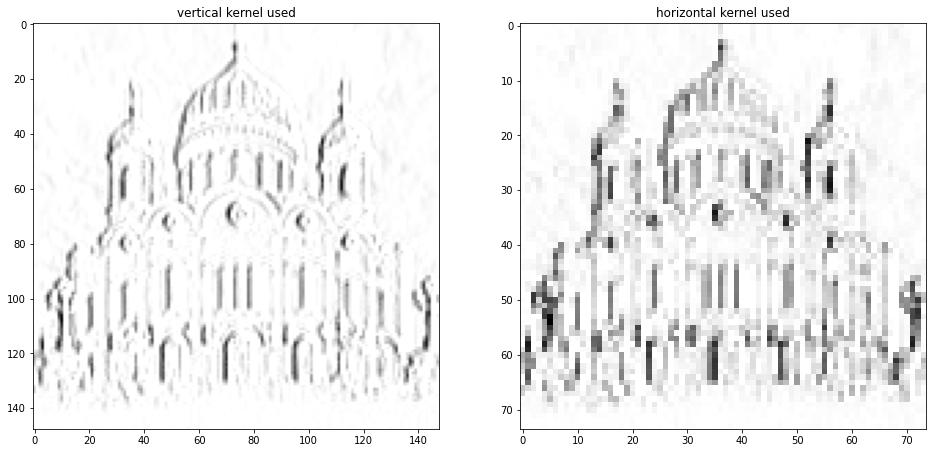

In [54]:
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16,9))

ax1.imshow(activation_map.squeeze().detach().numpy(), cmap='binary')
ax1.set_title('vertical kernel used')

ax2.imshow( pMap.squeeze().detach().numpy(), cmap='binary' )
ax2.set_title('horizontal kernel used')

plt.show()